# NFL Big Data Bowl - Random Forest Model for X, Y Prediction

Some changes compared to the initial notebook


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import plot_tree
import glob
import os

## Data Loading

In [ ]:
from pathlib import Path

DATA_DIR = Path("nfl-big-data-bowl-2026-prediction")

# Load all CSV files from train folder
train_input_files = sorted(glob.glob(str(DATA_DIR /'train'/'input_*.csv')))
train_output_files = sorted(glob.glob(str(DATA_DIR /'train'/'output_*.csv')))

print(f'Input files: {len(train_input_files)}')
print(f'Output files: {len(train_output_files)}')

Input files: 18
Output files: 18


In [ ]:
# Combine data
input_dfs = []
output_dfs = []

for input_file, output_file in zip(train_input_files, train_output_files):
    input_df = pd.read_csv(input_file)
    output_df = pd.read_csv(output_file)
    input_dfs.append(input_df)
    output_dfs.append(output_df)

train_input = pd.concat(input_dfs, ignore_index=True)
train_output = pd.concat(output_dfs, ignore_index=True)

print(f'Train input shape: {train_input.shape}')
print(f'Train output shape: {train_output.shape}')

Train input shape: (4880579, 23)
Train output shape: (562936, 6)


In [ ]:
# Data Inspection
print("Input columns:")
print(train_input.columns.tolist())
print("\nOutput columns:")
print(train_output.columns.tolist())
print("\nInput sample:")
display(train_input.head())
print("\nOutput sample:")
display(train_output.head())

Input columns:
['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y']

Output columns:
['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y']

Input sample:


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22



Output sample:


,game_id,play_id,nfl_id,frame_id,x,y
0,2023090700,101,46137,1,56.22,17.28
1,2023090700,101,46137,2,56.63,16.88
2,2023090700,101,46137,3,57.06,16.46
3,2023090700,101,46137,4,57.48,16.02
4,2023090700,101,46137,5,57.91,15.56


## Data Preprocessing

In [ ]:
# Filter only players to predict
train_input_filtered = train_input[train_input['player_to_predict'] == True].copy()
print(f'Filtered input shape: {train_input_filtered.shape}')

Filtered input shape: (1303440, 23)


In [ ]:
# Merge input and output data
merged_data = train_input_filtered.merge(
    train_output,
    on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
    suffixes=('_input', '_output')
)

print(f'Merged data shape: {merged_data.shape}')
display(merged_data.head())

Merged data shape: (560426, 25)


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,y_input,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,x_output,y_output
0,2023090700,101,True,46137,1,right,42,Justin Reid,6-1,204,...,20.69,0.31,0.49,79.43,267.68,21,63.259998,-0.22,56.22,17.28
1,2023090700,101,True,46137,2,right,42,Justin Reid,6-1,204,...,20.66,0.36,0.74,118.07,268.66,21,63.259998,-0.22,56.63,16.88
2,2023090700,101,True,46137,3,right,42,Justin Reid,6-1,204,...,20.63,0.44,0.76,130.89,269.78,21,63.259998,-0.22,57.06,16.46
3,2023090700,101,True,46137,4,right,42,Justin Reid,6-1,204,...,20.61,0.48,0.62,134.50,269.78,21,63.259998,-0.22,57.48,16.02
4,2023090700,101,True,46137,5,right,42,Justin Reid,6-1,204,...,20.58,0.54,0.44,129.79,269.06,21,63.259998,-0.22,57.91,15.56


In [ ]:
# player_heightConvert to numeric(e.g., "6-1" -> 73 inches)
def height_to_inches(height_str):
    try:
        feet, inches = height_str.split('-')
        return int(feet) * 12 + int(inches)
    except:
        return np.nan

merged_data['player_height'] = merged_data['player_height'].apply(height_to_inches)


# Categorical variable encoding
merged_data['play_direction_encoded'] = (merged_data['play_direction'] == 'right').astype(int)

# One-hot encode player_position and player_role
position_dummies = pd.get_dummies(merged_data['player_position'], prefix='position')
role_dummies = pd.get_dummies(merged_data['player_role'], prefix='role')

merged_data = pd.concat([merged_data, position_dummies, role_dummies], axis=1)

# Feature engineering
merged_data['bmi'] = (merged_data['player_weight'] / merged_data['player_height']**2) * 703

# Feature Selection
feature_columns = [
    'absolute_yardline_number',
    'player_height',
    'player_weight',
    'x_input',  # Current x coordinate
    'y_input',  # Current y coordinate
    's',  # Speed
    'a',  # Acceleration
    'dir',  # Direction
    'o',  # Orientation
    'num_frames_output',  # Number of frames to predict
    'ball_land_x',  # Ball landing x
    'ball_land_y',  # Ball landing y
    'bmi' # Body Mass Index
]

feature_columns.append('play_direction_encoded')
feature_columns.extend(position_dummies.columns.tolist())
feature_columns.extend(role_dummies.columns.tolist())

# Handle missing values
X = merged_data[feature_columns].fillna(0)
y_x = merged_data['x_output']
y_y = merged_data['y_output']

print(f'Features shape: {X.shape}')
print(f'Target X shape: {y_x.shape}')
print(f'Target Y shape: {y_y.shape}')

Features shape: (560426, 33)
Target X shape: (560426,)
Target Y shape: (560426,)


## Data Split

In [ ]:
# Split into training and validation data
# y_trainConvert to 2D array (predict x, y coordinates simultaneously)
y = np.column_stack([y_x, y_y])
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')
print(f'Target shape: {y_train.shape} (samples, [x, y])')

Training set size: 448340
Validation set size: 112086
Target shape: (448340, 2) (samples, [x, y])




```
# This is formatted as code
```

## Model Training

In [ ]:
# Random Forest model to predict X and Y coordinates simultaneously
print("Training Random Forest for X and Y coordinates...")
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rf.fit(X_train, y_train)
print("Model training completed!")

Training Random Forest for X and Y coordinates...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.6min


Model training completed!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.1min finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.2s finished


np.float64(2.0132868207461883)

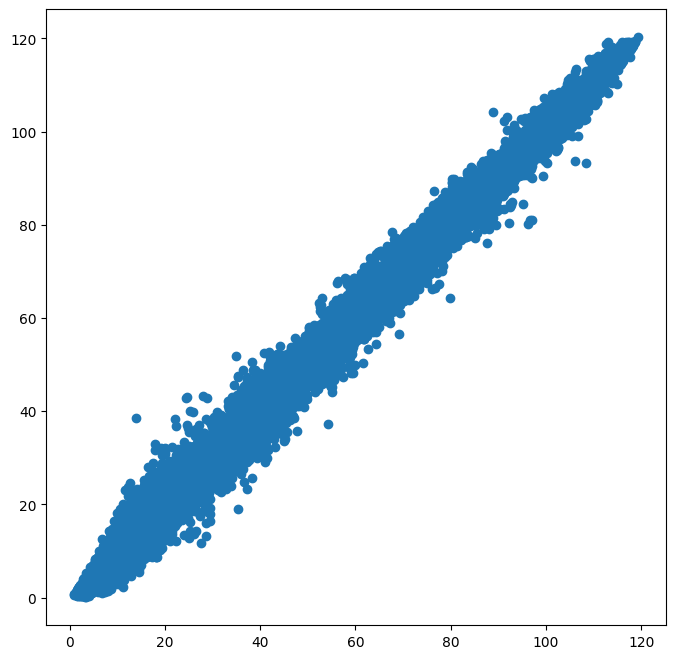

In [ ]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = rf.predict(X_val)
ax.scatter(y_hat_bag, y_val)
np.mean((y_val - y_hat_bag)**2)

Importance of features

In [ ]:
feature_imp = pd.DataFrame(
    {'importance':rf.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
ball_land_x,7.020167e-01
ball_land_y,1.754903e-01
x_input,5.519881e-02
y_input,2.913294e-02
s,5.463127e-03
dir,5.414910e-03
absolute_yardline_number,4.324528e-03
o,4.205608e-03
num_frames_output,3.987992e-03
play_direction_encoded,3.166892e-03


from matplotlib import pyplot as plt
_df_0['importance'].plot(kind='hist', bins=20, title='importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['importance'].plot(kind='line', figsize=(8, 4), title='importance')
plt.gca().spines[['top', 'right']].set_visible(False)

#Data Visualisation of the tree

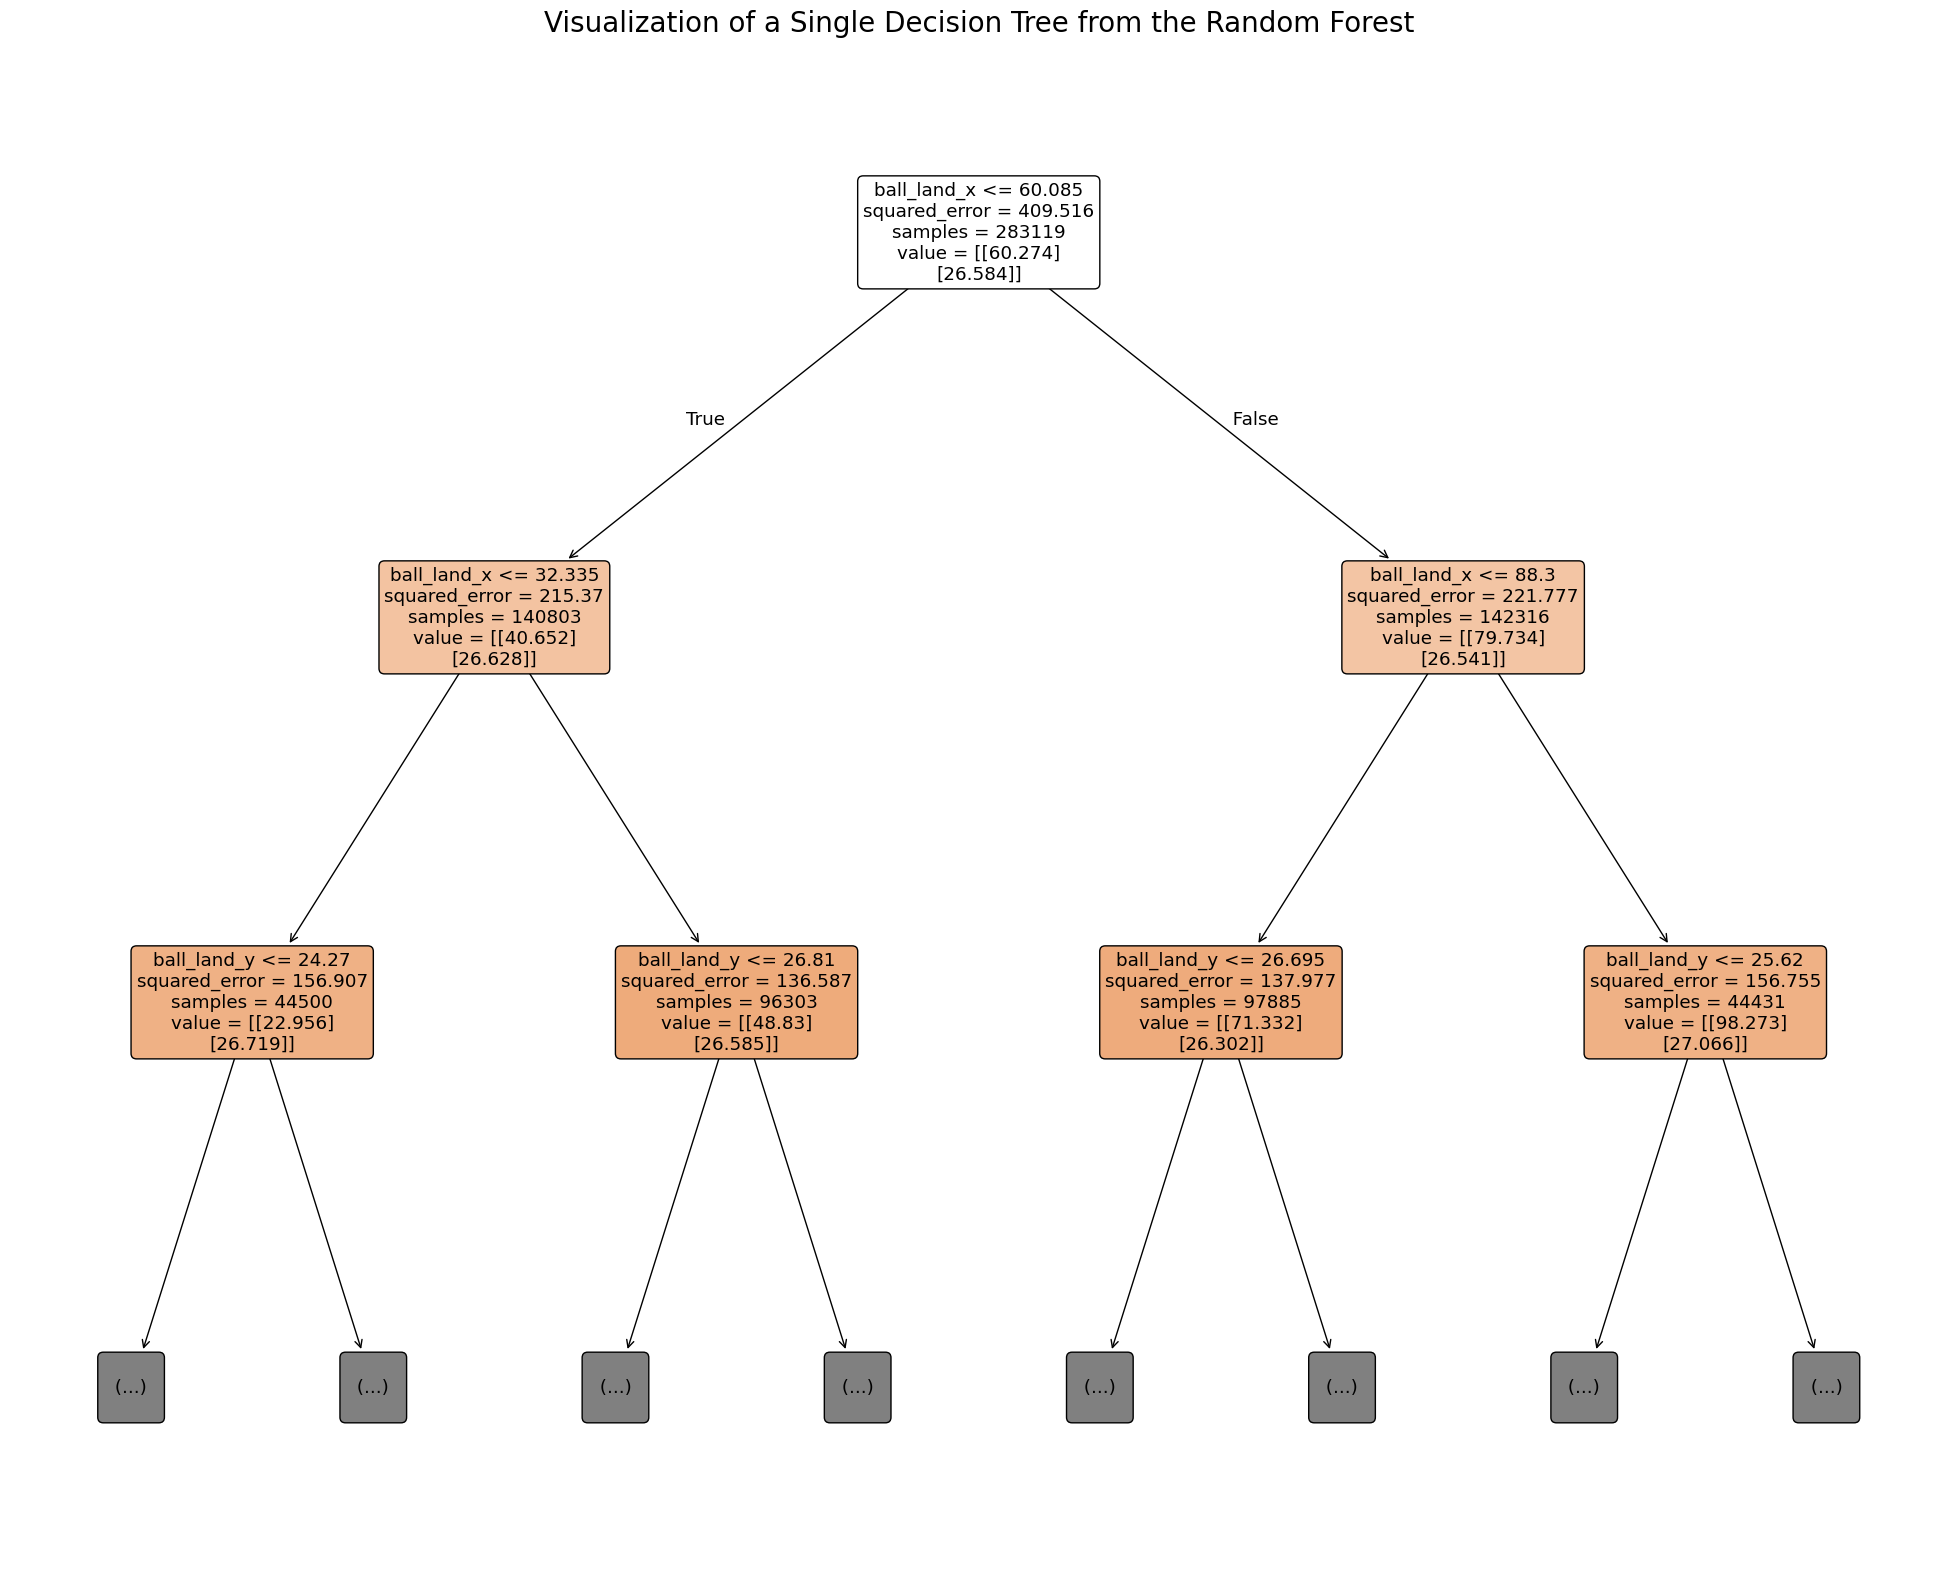

In [ ]:
# Set the feature names
feature_names = X_train.columns.tolist()

# Pick one tree from the forest, e.g., the first one
single_tree = rf.estimators_[0]

# Set the size of the figure
plt.figure(figsize=(25, 20))

# Visualize the tree
# We use max_depth to keep the plot readable. Remove it to see the full tree.
plot_tree(single_tree,
          feature_names=feature_names,
          filled=True,
          rounded=True,
          max_depth=2) # Use max_depth to control how deep the plot is

plt.title("Visualization of a Single Decision Tree from the Random Forest", fontsize=20)
plt.show()

## Model Evaluation

In [ ]:
# Prediction on validation data
predictions = rf.predict(X_val)
y_x_pred = predictions[:, 0]
y_y_pred = predictions[:, 1]

y_x_val = y_val[:, 0]
y_y_val = y_val[:, 1]

# X coordinate evaluation
mse_x = mean_squared_error(y_x_val, y_x_pred)
mae_x = mean_absolute_error(y_x_val, y_x_pred)
rmse_x = np.sqrt(mse_x)

print("X coordinate metrics:")
print(f"  MSE: {mse_x:.4f}")
print(f"  RMSE: {rmse_x:.4f}")
print(f"  MAE: {mae_x:.4f}")

# Y coordinate evaluation
mse_y = mean_squared_error(y_y_val, y_y_pred)
mae_y = mean_absolute_error(y_y_val, y_y_pred)
rmse_y = np.sqrt(mse_y)

print("\nY coordinate metrics:")
print(f"  MSE: {mse_y:.4f}")
print(f"  RMSE: {rmse_y:.4f}")
print(f"  MAE: {mae_y:.4f}")

# Overall error (Euclidean distance)
euclidean_distances = np.sqrt((y_x_val - y_x_pred)**2 + (y_y_val - y_y_pred)**2)
mean_euclidean_distance = euclidean_distances.mean()

print(f"\nMean Euclidean Distance: {mean_euclidean_distance:.4f}")

# Overall RMSE
overall_rmse = np.sqrt((rmse_x**2 + rmse_y**2) / 2)
print(f"\n=== Final RMSE: {overall_rmse:.4f} ===")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.5s


X coordinate metrics:
  MSE: 1.8738
  RMSE: 1.3689
  MAE: 0.9457

Y coordinate metrics:
  MSE: 2.1528
  RMSE: 1.4672
  MAE: 1.0470

Mean Euclidean Distance: 1.5718

=== Final RMSE: 1.4189 ===


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    4.3s finished


# Model validation

In [ ]:
# empty

## Create Submission

In [ ]:
# Verify prediction on sample data
sample_idx = 0
sample_input = X_val.iloc[[sample_idx]]

prediction = rf.predict(sample_input)[0]
pred_x = prediction[0]
pred_y = prediction[1]

actual_x = y_val[sample_idx, 0]
actual_y = y_val[sample_idx, 1]

print(f"Predicted: ({pred_x:.2f}, {pred_y:.2f})")
print(f"Actual: ({actual_x:.2f}, {actual_y:.2f})")
print(f"Error: {np.sqrt((pred_x - actual_x)**2 + (pred_y - actual_y)**2):.2f}")

Predicted: (82.87, 19.26)
Actual: (84.73, 19.95)
Error: 1.98


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
# Load test data
test_input = pd.read_csv(DATA_DIR / 'test_input.csv')
test = pd.read_csv(DATA_DIR / 'test.csv')

print(f'Test input shape: {test_input.shape}')
print(f'Test shape: {test.shape}')

# Filter only players to predict
test_input_filtered = test_input[test_input['player_to_predict'] == True].copy()
print(f'Filtered test input shape: {test_input_filtered.shape}')

Test input shape: (49753, 23)
Test shape: (5837, 4)
Filtered test input shape: (13254, 23)


In [ ]:
# Test data feature processing (same as training data)
test_input_filtered['play_direction_encoded'] = (test_input_filtered['play_direction'] == 'right').astype(int)

# player_heightConvert to numeric
test_input_filtered['player_height'] = test_input_filtered['player_height'].apply(height_to_inches)

# Rename columns to _input (match training data)
test_input_filtered = test_input_filtered.rename(columns={'x': 'x_input', 'y': 'y_input'})

# One-hot encode player_position and player_role
test_position_dummies = pd.get_dummies(test_input_filtered['player_position'], prefix='position')
test_role_dummies = pd.get_dummies(test_input_filtered['player_role'], prefix='role')
test_input_filtered['bmi'] = (test_input_filtered['player_weight'] / (test_input_filtered['player_height']**2)) * 703

# Adjust to have same columns as training data
for col in position_dummies.columns:
    if col not in test_position_dummies.columns:
        test_position_dummies[col] = 0

for col in role_dummies.columns:
    if col not in test_role_dummies.columns:
        test_role_dummies[col] = 0

test_features = pd.concat([test_input_filtered, test_position_dummies, test_role_dummies], axis=1)

# Feature selection (same order as training data)
X_test = test_features[feature_columns].fillna(0)

print(f'Test features shape: {X_test.shape}')

Test features shape: (13254, 33)


In [ ]:
# Predict on test data
print('Predicting test data...')
test_predictions = rf.predict(X_test)
test_pred_x = test_predictions[:, 0]
test_pred_y = test_predictions[:, 1]

# Add predictions to test_input_filtered
test_input_filtered['pred_x'] = test_pred_x
test_input_filtered['pred_y'] = test_pred_y

print(f'Predictions completed: {len(test_pred_x)} samples')
print(f'Sample predictions:')
print(test_input_filtered[['game_id', 'play_id', 'nfl_id', 'frame_id', 'pred_x', 'pred_y']].head())

Predicting test data...
Predictions completed: 13254 samples
Sample predictions:
       game_id  play_id  nfl_id  frame_id     pred_x     pred_y
45  2024120805       74   54586         1  84.097188  41.868166
46  2024120805       74   54586         2  84.061730  41.982981
47  2024120805       74   54586         3  84.095852  42.098600
48  2024120805       74   54586         4  84.075582  42.211220
49  2024120805       74   54586         5  84.097369  42.284683


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


In [ ]:
# submission.csvCreation
# Create ID matching test.csv format
submission = test.copy()
submission['id'] = submission['game_id'].astype(str) + '_' + \
                   submission['play_id'].astype(str) + '_' + \
                   submission['nfl_id'].astype(str) + '_' + \
                   submission['frame_id'].astype(str)

# Merge predictions
test_pred_df = test_input_filtered[['game_id', 'play_id', 'nfl_id', 'frame_id', 'pred_x', 'pred_y']].copy()
submission = submission.merge(
    test_pred_df,
    on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
    how='left'
)

# Final submission format
submission_final = submission[['id', 'pred_x', 'pred_y']].rename(columns={'pred_x': 'x', 'pred_y': 'y'})

# Fill missing values with 0 (as precaution)
submission_final = submission_final.fillna(0)

# Save to CSV
submission_final.to_csv("./submission.csv", index=False)